In [2]:
## Standard libraries
import os
import numpy as np
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy
import pickle
import re

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN
from torchvision import transforms

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
pl.seed_everything(42)

# Import tensorboard
%load_ext tensorboard

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "raw_data/seed-v/merged_data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/seed-v"

In [4]:
class SEEDV(data.Dataset):
    def __init__(self, emotion_dict, num_participants, data_dir):
        self.emotion_dict = emotion_dict
        self.num_participants = num_participants
        self.data_dir = data_dir
        self.tensor_dataset = self.load_data()
    
    def load_data(self):
        dataset = None           
        for file in os.listdir(self.data_dir):
            file_path = os.path.join(self.data_dir, file)
            if dataset is None:
                target = int(re.findall("\d+", file)[0])
                for i in range(1, len(np.load(file_path))):
                    target = np.hstack((target, int(re.findall("\d+", file)[0])))
                dataset = np.load(file_path)
            else:
                for i in range(len(np.load(file_path))):
                    target = np.hstack((target, int(re.findall("\d+", file)[0])))
                dataset = np.vstack((dataset, np.load(file_path)))

        tensor_dataset = data.TensorDataset(torch.from_numpy(dataset[:, :-1]), torch.from_numpy(dataset[:, -1]), torch.from_numpy(target))
                    
        return tensor_dataset
    
    def get_all_data(self):
        """
        same as self.__getitem__(self, idx) but instead of a specific index
        this function will return all the tuple that contains all features and 
        combined labels 
        """
        all_features = None
        all_combined_labels = None

        for idx in range(len(self.tensor_dataset)):
            if all_features == None:
                all_features, all_combined_labels = self.__getitem__(idx)
            else:
                features, combined_labels = self.__getitem__(idx)
                all_features = torch.vstack((all_features, features))
                all_combined_labels = torch.vstack((all_combined_labels, combined_labels))
        
        return all_features, all_combined_labels

    def __len__(self):
        return len(self.landmarks_frame)
        
    def __getitem__(self, idx):
        """
        return a tuple of features, combined_label (from participant and emotion)
        p1: 0 1 2 3 4,
        p2: 5 6 7 8 9,
        ...
        p16: 75 76 77 78 79

        we are only given participant # and emotion #
        p1_0: 0 = (1 - 1) * 5
        p1_1: 1 = 0 + 1
        p1_2: 2 = 0 + 2
        p1_3: 3 = 0 + 3
        p1_4: 4 = 0 + 4
        p2_0: 5 = (2 - 1) * 5
        p2_1: 6 = 5 + 1
        p2_2: 7 = 5 + 2
        p2_3: 8 = 5 + 3
        p2_4: 9 = 5 + 4
        ..
        p16_0: 75 = (16 - 1) * 5 = 75
        ...
        """
        features = self.tensor_dataset[idx][0]
        emotion_num = self.tensor_dataset[idx][1]
        participant_num = self.tensor_dataset[idx][2]
        base = (participant_num - 1) * len(self.emotion_dict)
        combined_label = base + emotion_num

        return features, combined_label

In [5]:
seed_v = SEEDV(emotion_dict = {0: 'disgust', 1: 'fear', 2: 'sad', 3: 'neutral', 4: 'happy'}, num_participants=16, data_dir=DATASET_PATH)

In [6]:
classes = torch.randperm(5*16) # Generate random permutation of numbers from 0 to 79
train_classes, val_classes, test_classes = classes[:64], classes[64:72], classes[72:] # 80-10-10 split

In [7]:
SEEDV_all_features, SEEDV_all_labels = seed_v.get_all_data()

In [8]:
class EEGDataset(data.Dataset):
    def __init__(self, features, labels):
        super().__init__()
        self.features = features
        self.labels = labels

    def __getitem__(self, idx):
        features, labels = self.features[idx], self.labels[idx]

        return features, labels

    def __len__(self):
        return self.features.shape[0]

In [9]:
def dataset_from_labels(features, labels, class_set): 
    class_mask = (labels == class_set).any(dim=-1) # instead of [[64], [64],... ] -> [64, 64, ...]
    return EEGDataset(features[class_mask], labels[class_mask])

In [10]:
train_set = dataset_from_labels(
    SEEDV_all_features, SEEDV_all_labels, train_classes)
val_set = dataset_from_labels(
    SEEDV_all_features, SEEDV_all_labels, val_classes)
test_set = dataset_from_labels(
    SEEDV_all_features, SEEDV_all_labels, test_classes)

In [11]:
class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which 
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but 
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in 
                           the beginning, but kept constant across iterations 
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for 
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it*self.N_way:(it+1)*self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c]:start_index[c]+self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

In [12]:
N_WAY = 5 # 5 because 5 classes/emotions.
K_SHOT = 4 # how many samples the model can have to learn from per class.
train_data_loader = data.DataLoader(train_set,
                                    batch_sampler=FewShotBatchSampler(train_set.labels,
                                                                      include_query=True,
                                                                      N_way=N_WAY,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=True),
                                    num_workers=4)
val_data_loader = data.DataLoader(val_set,
                                  batch_sampler=FewShotBatchSampler(val_set.labels,
                                                                    include_query=True,
                                                                    N_way=N_WAY,
                                                                    K_shot=K_SHOT,
                                                                    shuffle=False,
                                                                    shuffle_once=True),
                                  num_workers=4)

In [13]:
def split_query_support(features, labels):
    support_features, query_features = features.chunk(2, dim=0)
    support_labels, query_labels = labels.chunk(2, dim=0)
    return support_features, query_features, support_labels, query_labels

In [38]:
features, labels = next(iter(val_data_loader))
support_features, query_features, support_labels, query_labels = split_query_support(features, labels)

# fig, ax = plt.subplots(1, 2, figsize=(8, 5))
# ax[0].plot(support_features, 'o')
# ax[0].set_title("Support set")
# ax[0].axis('off')
# ax[1].plot(query_features, 'o')
# ax[1].set_title("Query set")
# ax[1].axis('off')
# plt.suptitle("Few Shot Batch", weight='bold')
# plt.show()
# plt.close()

In [39]:
# Normalize the features
support_features_norm = support_features / support_features.max(0, keepdim=True)[0]
query_features_norm = query_features / query_features.max(0, keepdim=True)[0]

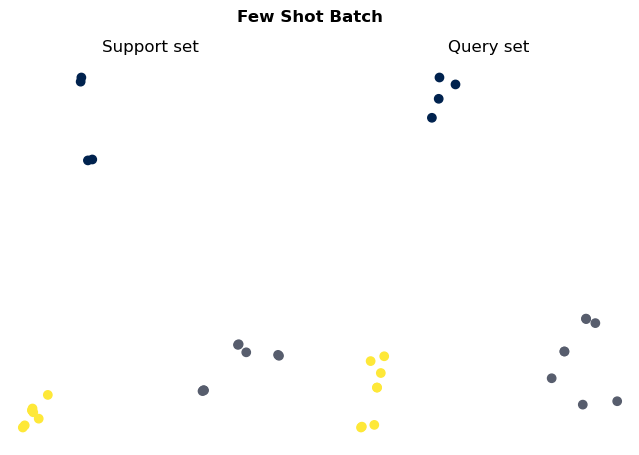

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
support_pca = pca.fit_transform(support_features_norm)
query_pca = pca.fit_transform(query_features_norm)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(support_pca[:,0], support_pca[:,1], c=support_labels)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].scatter(query_pca[:,0], query_pca[:,1], c=query_labels)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show()
plt.close()